Imports!

In [1]:
%matplotlib inline

import h5py

from keras.optimizers import SGD
from keras.utils.visualize_util import to_graph

from IPython.display import SVG

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

from train import infer_sizes
from models import vggnet16_regressor_model

Using gpu device 2: Tesla K80 (CNMeM is enabled)
/home/sam/repos/joint-regressor/keras/env/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Using Theano backend.


Now load up our data H5 and grab some trained weights for our model.

In [2]:
# Load data and get a model
train_h5_path = '../cache/train-patches-mpii/samples-000001.h5-repacked'
val_h5_path = '../cache/val-patches-mpii/samples-000001.h5'
train_h5 = h5py.File(train_h5_path, 'r')
val_h5 = h5py.File(val_h5_path, 'r')
data = train_h5['data']
labels = train_h5['label']
val_data = val_h5['data']
val_labels = val_h5['label']
input_shape, reg_outs, class_outs = infer_sizes(train_h5_path)
sgd = SGD(lr=0.0001, nesterov=True, momentum=0.9)
model = vggnet16_regressor_model(input_shape, reg_outs, sgd, 'glorot_normal')
model.load_weights('../cache/keras-checkpoints/model-iter-384-r405629.h5')

Start by doing a basic visualisation of our model and inspecting the shape of our data.

# Data shapes
train data:  (87360, 8, 224, 224)
train labels:  (87360, 6)
val data:  (1249, 8, 224, 224)
val labels:  (1249, 6)

# Network


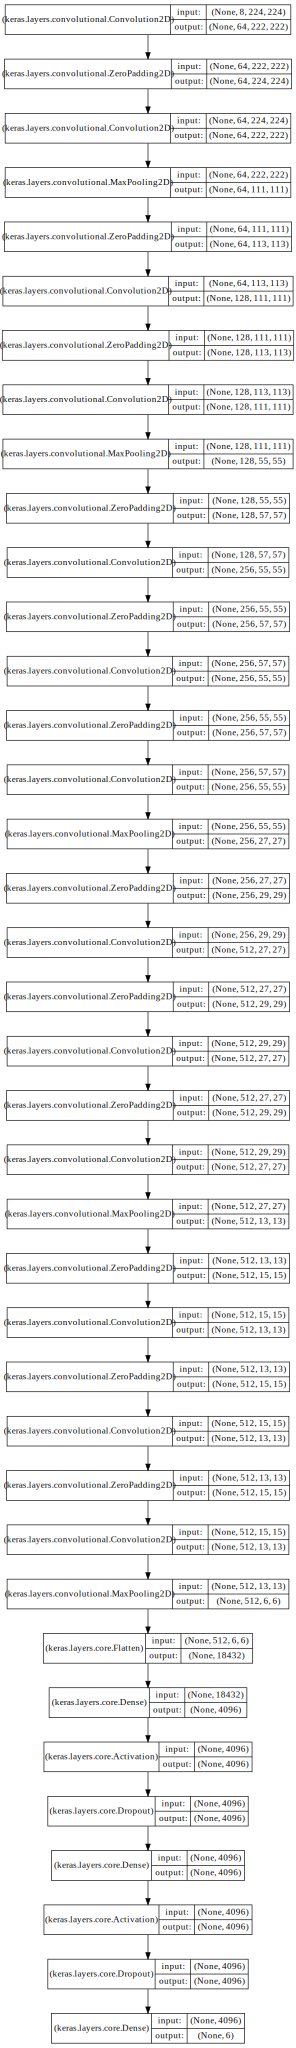

In [3]:
print '# Data shapes'
print 'train data: ', data.shape
print 'train labels: ', labels.shape
print 'val data: ', val_data.shape
print 'val labels: ', val_labels.shape
print
print '# Network'
SVG(to_graph(model, show_shape=True).create(prog='dot', format='svg'))

Now write some functions to look at our data and also a few utilities for doing forward prop. These will be useful for inspecting activations and gradients, as well as verifying that I've written what I wanted to write to the file.

Note that some of these images will look weird because they've been padded (where necessary) with their edge pixel values. This is true of the flow as well.

Datum 717
[[ 0.         -5.50368547]
 [ 9.1728096   0.        ]
 [-5.50368547  9.1728096 ]]


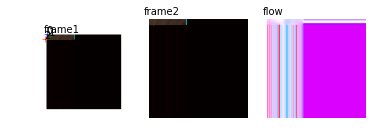

Datum 820
[[  0.          26.64516068]
 [ 46.96774292   0.        ]
 [ 26.64516068  46.96774292]]


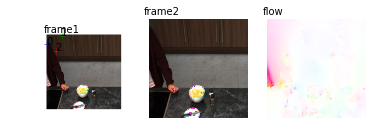

Datum 1239
[[  0.          -2.73427224]
 [-15.77464771  -1.05164313]
 [ -2.73427224 -15.1436615 ]]


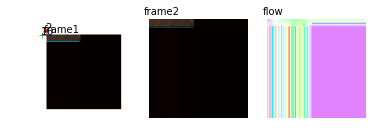

Datum 42
[[  0.          26.77551079]
 [-27.4285717    0.        ]
 [ 24.81632614 -27.4285717 ]]


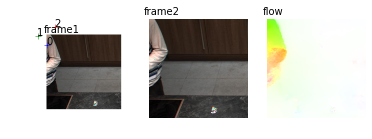

Datum 1130
[[  0.          -3.11111116]
 [-18.40740776   0.        ]
 [ -3.11111116 -18.40740776]]


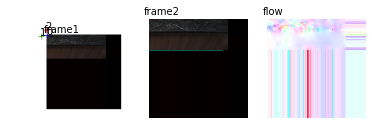

Datum 450
[[  0.          14.36981106]
 [  3.38113213  -2.11320758]
 [ 13.94717026  -3.38113213]]


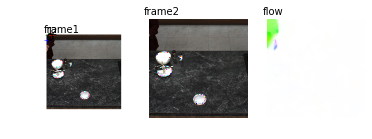

Datum 258
[[ 0.          7.88930798]
 [ 2.53584909  0.        ]
 [ 8.45283031  3.38113213]]


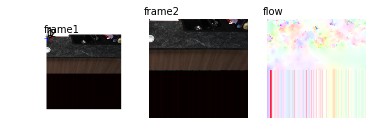

Datum 697
[[ 0.        -5.090909 ]
 [-3.5        0.       ]
 [-5.090909  -4.4545455]]


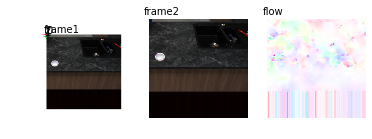

Datum 629
[[ 0.         -5.090909  ]
 [-3.5         0.        ]
 [-5.090909   -2.22727275]]


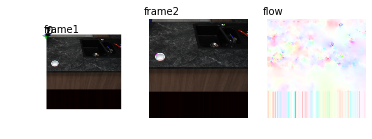

Datum 347
[[  0.           5.26858854]
 [ 11.04704094   0.        ]
 [  3.39908957  10.87708664]]


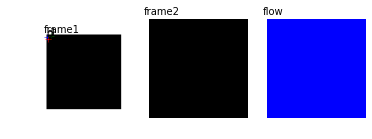

In [13]:
def _reshape_im(im):
    # images are stored channels-first, but numpy expects
    # channels-last
    return np.transpose(im, axes=(1, 2, 0))

def _vis_flow(flow):
    # clean visualisation of flow with angle of movement as
    # hue, magnitude as saturation and a constant V of 1
    x, y = flow
    # normed-log makes things stand out quite a bit
    mags = np.log(np.sqrt(x**2 + y**2) + 1)
    norm_mags = mags / max(mags.flatten())
    angles = (np.arctan2(x, y) + np.pi) / (2 * np.pi)
    ones = np.ones_like(angles)
    hsv = np.stack((angles, norm_mags, ones), axis=2)
    return hsv_to_rgb(hsv)

def _label_to_coords(label):
    # We're just undoing Matlab's flattening mechanism,
    # which is different to numpy's mechanism.
    return label.reshape((2, -1)).T

def _plot_label(label):
    # plot a label corresponding to a flattened joint vector
    coords = _label_to_coords(label)
    print(coords)
    for idx, coord in enumerate(coords):
        plt.plot(coord[0], coord[1], marker='+')
        plt.text(coord[0], coord[1], str(idx))

def show_datum(datum, label=None):
    # First frame
    im1 = _reshape_im(datum[:3])
    plt.subplot(131)
    plt.imshow(im1)
    plt.axis('off')
    plt.text(-10, -10, 'frame1')
    
    if label is not None:
        _plot_label(label)
    
    # Second frame
    im2 = _reshape_im(datum[3:6])
    plt.subplot(132)
    plt.imshow(im2)
    plt.axis('off')
    plt.text(-10, -10, 'frame2')
    
    # Optical flow
    flow = _vis_flow(datum[6:])
    plt.subplot(133)
    plt.imshow(flow)
    plt.axis('off')
    plt.text(-10, -10, 'flow')
    plt.show()

for i in np.random.permutation(len(val_labels))[:10]:
    print 'Datum', i
    show_datum(val_data[i], label=val_labels[i])

In [5]:
from scipy.io import loadmat
m = loadmat('../cache/mpii_data.mat')

In [6]:
mpii_data = m['mpii_data']
mpii_data[(0, 0)]

([[1345]], [u'datasets/mpii-cooking-pose-challenge-continuous/data/images/img_001345_002706.jpg'], [[797, 435], [816, 667], [707, 447], [872, 422], [705, 594], [902, 542], [797, 644], [908, 580], [831, 642], [923, 577], [795, 302], [810, 440]])